In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa, soundfile as sf

In [2]:
ABS_PATH = os.path.dirname(os.path.dirname(os.path.abspath("")))
SRC_PATH = os.path.join(ABS_PATH, "static", "audios", "0_src")
OUT_PATH = os.path.join(ABS_PATH, "static", "audios", "1_noise_reduced")

In [ ]:
class AudioWorker():
    
    def __init__(self, audio_path):
        self.audio_path = audio_path
        
        self.sample_rate, self.samples = wavfile.read(audio_path)
        if len(self.samples.shape)==2:
            self.samples = np.array(self.samples[:,0], dtype=float)     # make it 1D
        else: self.samples = np.array(self.samples, dtype=float)
        
    def get_mel_specs(self):
        specs = librosa.feature.melspectrogram(y=self.samples, sr=self.sample_rate, n_mels=128, fmax=20000) 
        specs_dB = librosa.power_to_db(specs, ref=np.max)
        return specs_dB
                
        
    
    def segmentation(self, specs, save_fig=False):
        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(3), mode="same")        # ma = moving average
        cut_indices = np.where(specs_maxs_ma>specs_maxs_ma.mean(), 1, 0)
        
        cut_indices = np.convolve(cut_indices, np.ones(10), mode="same")        # erosion
        cut_indices = np.where(cut_indices==10, 1, 0)                       
        cut_indices = np.convolve(cut_indices, np.ones(80), mode="same")        # dilatation -> establishes padding after onset and before offset, remaining signals are elongated to be at least 80 "segments" long
        cut_indices = np.where(cut_indices>=1, 1, 0)
        
        # To get on and offsets
        diff = cut_indices[1:] - cut_indices[:-1]
        offsets = np.where(diff==-1)
        onsets = np.where(diff==1)
        
        # Just for plotting
        cut_indices = np.where(cut_indices>=1)
        
        
        fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)

        times = librosa.times_like(specs, sr=self.sample_rate)
        img = librosa.display.specshow(specs,
                                        x_axis='time', y_axis='mel', sr=self.sample_rate, fmax=20000, ax=ax)
        ax.vlines(times[cut_indices], 0, 20000, alpha=0.05, color="y")
        ax.vlines(times[onsets], 0, 20000, color="g", alpha=0.7)
        ax.vlines(times[offsets], 0, 20000, color="r", alpha=0.3)
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-segmentation.png")
        
        intervals = (times[onsets], times[offsets])
        onsets, offsets = list(intervals[0]), list(intervals[1])

        # original code, resulting in negative times
        # pauses = [onset-offset for onset, offset in zip(onsets, offsets)]
        # onsets.insert(0,0)
        # singing = [-(onset-offset) for onset, offset in zip(onsets, offsets)]
        
        singing = [(offset-onset) for onset, offset in zip(onsets, offsets)]
        pauses = [(onset-offset) for onset, offset in zip(onsets[1:], offsets)]        
        
        ax.set_title(f"{os.path.basename(self.audio_path)}     s_mean:{np.array(singing).mean():.1f}s     p_mean: {np.array(pauses).mean():.1f}s")
        return intervals
    
    
    def spec_freq_peaks(self, specs, save_fig=False):
        
    #     fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)
    #     img = librosa.display.specshow(specs,
    #                                     x_axis='time', y_axis='mel', ax=ax, sr=self.sample_rate)
    #     ax.set_title("Mel spectogram")
    #     times = librosa.times_like(specs, sr=self.sample_rate)

        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(10), mode="same")
        ax.vlines(times[np.where(specs_maxs_ma>specs_maxs_ma.mean())], 0, 1000, color="r")
        # ax.vlines(times[np.where(spec_diffs.mean(axis=0)>spec_diffs.mean())], 0, 1000)
        ax.scatter(times, specs_maxs**2, s=1, color="y", alpha=1)

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.suptitle(os.path.basename(self.audio_path))
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-freq_peaks.png")
        

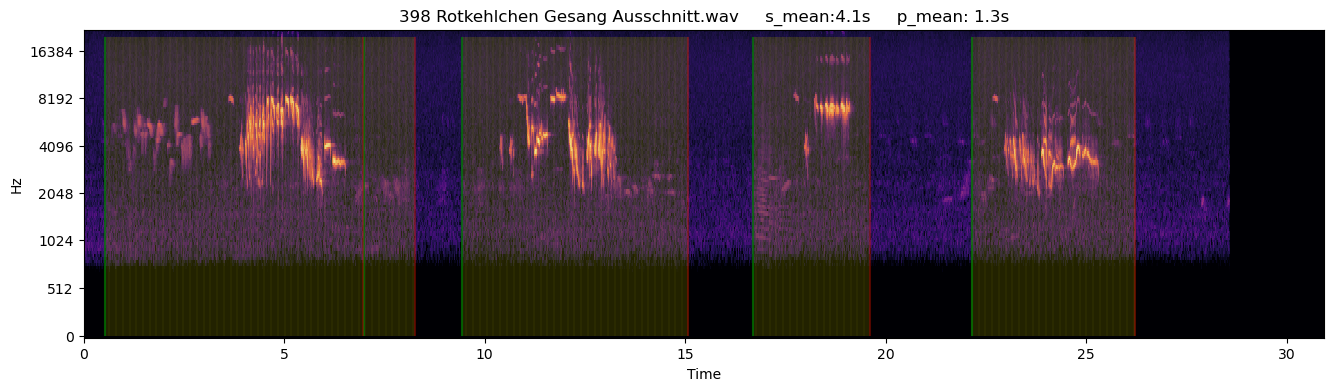

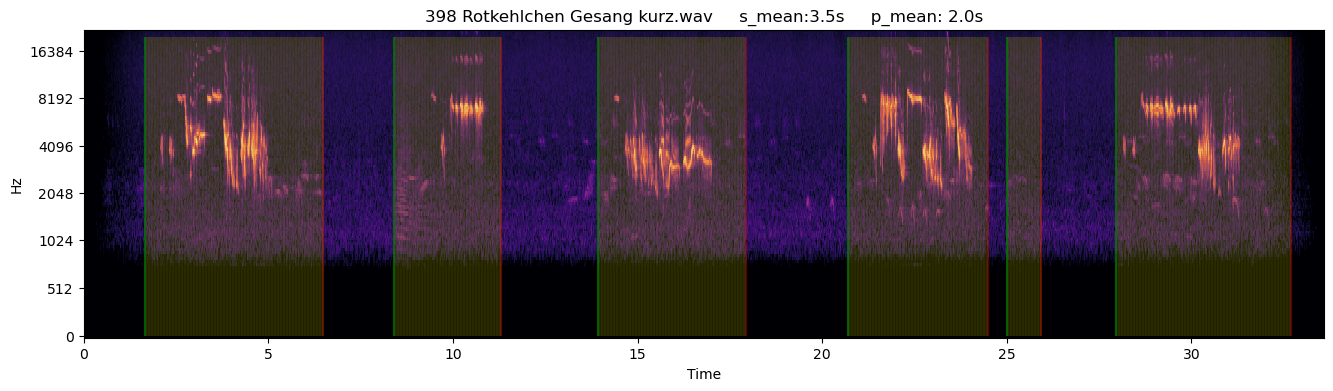

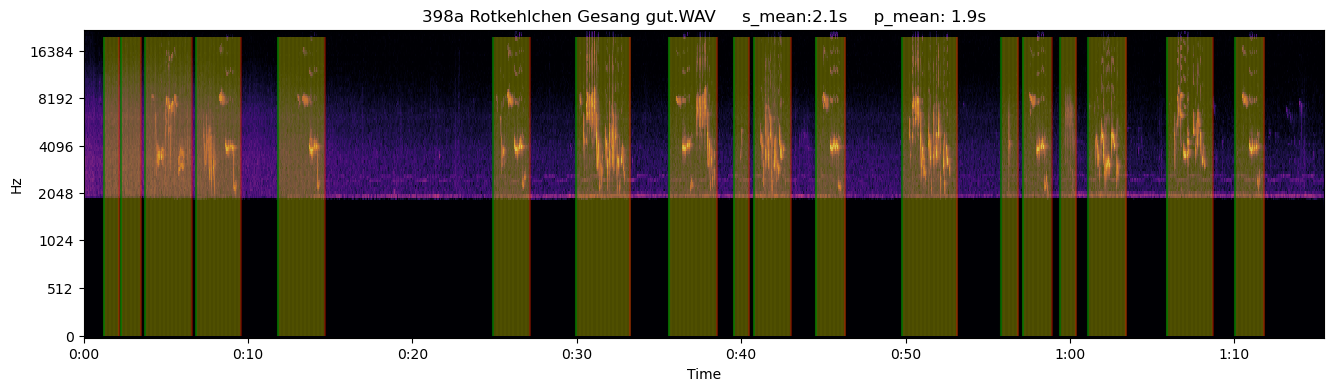

In [69]:
# init dict: CODE here
for fname in os.listdir(SRC_PATH)[1:4]:
    if fname.lower().endswith(".wav"):
        audio_path = os.path.join(SRC_PATH, fname)
        audioWorker = AudioWorker(audio_path=audio_path)
        specs = audioWorker.get_mel_specs()
        # audioWorker.plot_mel_spec(specs, save_fig=False)
        intervals = audioWorker.segmentation(specs, save_fig=False)

In [55]:
intervals

(array([ 1.01006803,  2.42648526,  3.49460317,  6.83827664, 11.83056689,
        24.92662132, 30.13950113, 35.59619048, 39.54358277, 40.76263039,
        44.52426304, 49.79519274, 55.83238095, 57.12108844, 59.41986395,
        61.12653061, 65.89823129, 70.05460317]),
 array([ 2.15945578,  3.42494331,  6.80344671,  9.54340136, 14.64018141,
        27.13251701, 33.27419501, 38.52190476, 40.48399093, 43.01496599,
        46.34702948, 53.13886621, 56.84244898, 58.88580499, 60.38349206,
        63.4369161 , 68.68462585, 71.81931973]))

In [79]:
librosa.mel_to_hz(461.20599292)

np.float64(2.104018105695139e+16)

In [77]:
mel_freqs_hz = librosa.mel_frequencies(
                    n_mels=128,
                    fmin=0,
                    fmax=20000,
                    htk=False)

In [78]:
mel_freqs_hz

array([    0.        ,    30.74706619,    61.49413239,    92.24119858,
         122.98826478,   153.73533097,   184.48239717,   215.22946336,
         245.97652956,   276.72359575,   307.47066195,   338.21772814,
         368.96479434,   399.71186053,   430.45892673,   461.20599292,
         491.95305912,   522.70012531,   553.44719151,   584.1942577 ,
         614.9413239 ,   645.68839009,   676.43545629,   707.18252248,
         737.92958868,   768.67665487,   799.42372107,   830.17078726,
         860.91785346,   891.66491965,   922.41198585,   953.15905204,
         983.90611823,  1015.22624295,  1047.93359348,  1081.69467048,
        1116.54342167,  1152.51488845,  1189.64524112,  1227.97181529,
        1267.5331494 ,  1308.36902347,  1350.52049913,  1394.02996084,
        1438.9411586 ,  1485.29925187,  1533.150855  ,  1582.54408411,
        1633.52860548,  1686.15568546,  1740.47824205,  1796.55089811,
        1854.43003625,  1914.17385555,  1975.84243011,  2039.49776939,
      